# </span><center> **Projet final : <span style="color:red"><ins>Seam Carving</ins></span>**</center>
#### <div style="text-align:right">(Hugo Vuillin, Robin Combes / Mono 1-A)</div>

___

## <ins>Objectif :</ins>

<div style="text-align:justify;">L'objectif de ce projet est d'implémenter en pyhton un algorithme permettant de réduire ou d'augmenter la taille d'une image (d'autres aspects seront explorés ultérieurement) en se basant sur une méthode développée en 2007 par les informaticiens israéliens Shai Avidan et Ariel Shamir, intitulée Seam Carving.</div>
<br>Cette méthode peut se décomposer en trois étapes principales :

1) <div style="text-align:justify;"><a id="ref_1"></a>La première étape consiste à attribuer aux pixels constituant une image initiale donnée, une certaine valeur qu'on appellera "énergie" et qui est destinée à quantifier leurs importances respectives au regard d'un certain critère arbitraire fixé : on considèrera ici le gradient d'intensité lumineuse pour chaque dimension du sytème RGB, ce qui revient à donner davantage d'importance aux pixels délimitant des interfaces entre différents éléments constituant l'image, autrement dit aux pixels qui marquent une rupture d'homogénéité des couleurs et dont la suppression, immédiatement perceptible par l'oeil, serait synonyme de perte d'informations ; </div>
<br> 
2) <div style="text-align:justify;">Une fois le "calque d'énergie" de l'image initiale obtenu, il s'agit ensuite d'identifier dans une seconde étape le chemin de pixels reliant le bord inférieur au bord supérieur de l'image, minimisant la somme des énergies respectives des pixels le constituant (on discutera dans la suite du choix de s'intérésser à un chemin de pixels plutôt qu'à une colonne de pixels ou encore à des pixels isolés); </div>
<br>
3) <div style="text-align:justify;">Enfin, on exploitera dans une troisième et dernière étape ce chemin de "moindre énergie" afin de pouvoir réduire ou augmenter la taille de l'image, ou encore en tentant d'en supprimer un élément précis. </div>

(<a href="#ref_2">retour $\downarrow _{\mathrm{II.1)}}$</a>)

Nous nous appuierons par ailleurs sur l'image test affichée çi-dessous, afin de pouvoir illustrer sur un exemple les différents points importants abordés tout au long de l'exposé de la démarche.

<center><img src="Image_test_3.jpg" alt="Drawing" style="width: 700px;"/></center>

In [4]:
"""Import des modules nécessaires"""
import sys
import heapq
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import PIL.Image

## I) <ins>Détermination du "calque d'énergie" de l'image</ins>

Pour déterminer le "calque d'énergie" de l'image, nous allons utiliser le filtre de Sobel. 


<div style="text-align:justify;">Ce filtre consiste à appliquer certaines matrices de convolution à l'image afin de mettre en évidence les contours des éléments qu'elle contient.
<br>La convolution est le processus consistant à ajouter chaque élément de l'image à ses voisins immédiats, pondéré par les éléments du noyau (i.e. les éléments de la matrice de convolution considérée). On prendra garde au fait que les opérations matricielles effectuées (les convolutions) ne sont pas des multiplications traditionnelles de matrices malgré le fait que l'opération soit notée par un « * ».
<br>Par exemple, si nous avons deux matrices $3\times3$, la première étant le noyau et la seconde une partie de l'image, la convolution est le processus consistant à retourner les colonnes et les lignes du noyau puis à multiplier localement les valeurs ayant la même position, puis sommer le tout.</div>
<br><div style="text-align:justify;">Dans notre cas l'opérateur de Sobel revient à calculer une sorte de gradient d'intensité lumineuse dans des directions précises pour chaque pixel. Il permet alors de mettre en évidence les points de changement soudain de luminosité, correspondant probablement à des bords.</div>

<br>Les matrices composant cet opérateur sont :


$\mathrm{G_x=\begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}* A}$

$\mathrm{G_y=\begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}* A}$

On peut aussi l'écrire de manière plus simple comme:

$\mathrm{G_x=\begin{bmatrix}
1\\
2\\
1
\end{bmatrix}* 
\left(\begin{bmatrix}
1 & 0 & -1\\
\end{bmatrix}* A\right)}$ 

et 

$\mathrm{G_y=\begin{bmatrix}
1\\
0\\
-1
\end{bmatrix}* 
\left(\begin{bmatrix}
1 & 2 & 1\\
\end{bmatrix}* A\right)}$

Ici A est l'image et $*$ l'opérateur de convolution.

La deuxième écriture exhibe la raison pour laquelle on parle de gradient.
<br>Prenons la matrice $\mathrm{G_x}$, la deuxième écriture nous fait apparaitre la matrice:
\begin{bmatrix}1 & 0 & -1\\\end{bmatrix}
Cette dernière découle de la définition de la dérivée centrale pour un signal discret : $f'(x)=\frac{f(x+h)-f(x-h)}{2h}$. On retrouve le -1, le 0 et le 1 dans les termes de cette expression ce sont les facteurs devant  le $f(x)$.
Le fait d'écrire cette matrice en ligne effectue cette opération sur la matrice de pixel puis la matrice colonne permet de faire une mise à l'échelle et une moyenne pondérée de cette dérivée pour avoir un gradient selon l'axe $x$.
Le principe est analogue pour l'axe $y$ seulement la mise à l'échelle et la moyenne sont faites avant de dériver cette nouvelle matrice et d'avoir le gradient.


Intuitivement, nous pouvons considérer que le premier filtre remplace chaque pixel par la différence entre sa valeur en haut et sa valeur en bas. Le second filtre remplace chaque pixel par la différence entre les valeurs à sa droite et à sa gauche. Cela permet de capturer la tendance générale de variations d'intensités des couleurs des pixels dans cette zone de taille $3\times3$.


Ainsi pour avoir le gradient et récuperer l'image avec les contours on doit faire:
$ |G|=\sqrt{G_x^2+G_y^2}$

<ins>Remarque :</ins> &nbsp; Il est aussi possible en changeant les valeurs dans les matrices d'améliorer la netteté de l'image ou encore de la rendre plus floue.

Le programme çi dessous donne l'implémentation en python du filtre de Sobel ainsi que son application afin d'obtenir le "calque d'énergie" de l'image initiale.

In [5]:
"""Définition de la fonction permettant d'obtenir le calque d'énergie d'une image"""
def calc_energy(img):
    
    assert type(img)==np.ndarray
    img = img.astype(float)
    
    sobel_filter_dx_dim2 = np.array([[1.0, 2.0, 1.0],[0.0, 0.0, 0.0],[-1.0, -2.0, -1.0]])
    sobel_filter_dy_dim2 = np.array([[1.0, 0.0, -1.0],[2.0, 0.0, -2.0],[1.0, 0.0, -1.0]])
    
    sobel_filter_dx_dim3 = np.stack([sobel_filter_dx_dim2] * 3, axis=2)
    sobel_filter_dy_dim3 = np.stack([sobel_filter_dy_dim2] * 3, axis=2)
    
    convolved = np.sqrt((convolve(img, sobel_filter_dx_dim3))**2 + (convolve(img, sobel_filter_dy_dim3))**2)
    energy_map = convolved.sum(axis=2)
    
    return energy_map

On peut tester ce programme sur l'image test comme suit :

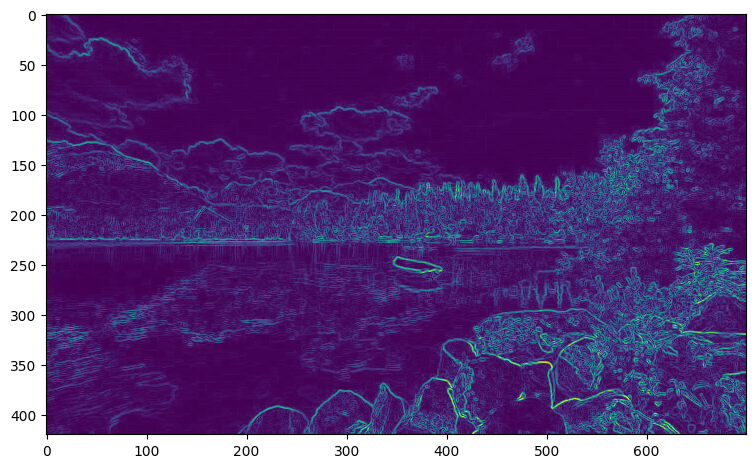

In [6]:
img=plt.imread("Image_test_3.jpg")
energy_map=calc_energy(img)
r, c= energy_map.shape
dpi = plt.rcParams['figure.dpi']
figsize = c/float(dpi), r/float(dpi)
fig=plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
plt.imshow(energy_map)
#plt.axis('off')
plt.show()

## II) <ins>Exploitation du calque d'énergie</ins>

### <a id="ref_2"></a>II.1) Identification du chemin de "moindre énergie"

<div style="text-align:justify;">Comme indiqué dans le <a href="#ref_1">point n°2 de la section Objectif</a>, il s'agit désormais de s'atteler à l'identification du chemin de "moindre énergie" au sein du "calque d'énergie" obtenu.
<br>On définit un chemin de pixels contenu dans une image donnée comme étant une famille finie de pixels (de cardinal la hauteur de l'image en pixels), de telle sorte que la position du $\mathrm{\small{i+1} ^e}$ pixel (sous entendu sur la $\mathrm{\small{i+1} ^e}$ ligne) est déterminée par celle du $\mathrm{i^e}$ pixel selon les liens représentés sur le schéma çi-après.
<br>L'intérêt de déterminer un tel chemin réside dans le fait qu'une modification de l'image initiale au voisinage de ce chemin (suppression ou addition d'un chemin à proximité), est celle qui "perturbe" le moins l'image dans la mesure où : 
<br>- elle préserve premièrement au maximum les pixels importants décrits précedemment<a href="#ref_1"> (point n°1 de la section Objectif)</a> ;
<br>- elle donne également globalement de meilleurs résultats que ceux que l'on aurait obtenus si l'on s'était intéressé à une modification au voisinage de pixels de "moindre énergie" isolés (déterminés ligne par ligne) qui aurait engendré des décalages perceptibles assez rapidement, ou encore au voisinage d'une colonne de "moindre énergie" qui aurait également engendré des discontinuités visibles pour des images plus détaillées présentant des éléments aux formes plus complexes.</div>

Plusieurs stratégies peuvent alors être adoptées afin de déterminer ce chemin de "moindre énergie".

<div style="text-align:justify;">Une première façon de procéder serait de transformer notre "calque d'énergie" de l'image initiale, originellement stocké sous forme de matrice de pixels à deux dimensions, en un graphe orienté pondéré dont les sommets seraient représentés par les pixels, et où le poids d'un arc reliant un sommet $\mathrm{S_1}$ à un sommet $\mathrm{S_2}$ situé au dessous du sommet $\mathrm{S_1}$ (i.e. sur la ligne suivante), prendrait la valeur de l'énergie du pixel représenté par le sommet situé au dessus, c'est à dire celle du sommet $\mathrm{S_1}$ ; en ayant à l'esprit qu'il existe en thérorie des graphes, un algorithme efficace (complexité polynomiale) permettant de déterminer le plus court chemin reliant deux sommets d'un graphe pondéré donné : l'algorithme de Dijkstra (découvert par le mathématicien et informaticien néerlandais Edsger Dijkstra en 1959) .</div>
<a id="ref_3"></a>Le schéma çi-dessous donne la représentation sous forme de graphe pour une image de définition (5x3) : (<a href="#ref_6">retour $\downarrow _{\mathrm{fin\,\,II.1)}}$</a>)

<img src="Schéma_graphe_image.png" alt="Drawing" style="width: 600px;"/>

On peux ainsi faire deux remarques principales concernant la structure de ce graphe :
- <div style="text-align:justify;">il a été premièrement nécessaire de rajouter deux pixels (/sommets) fictifs (un au dessus et un en dessous de l'image), car on souhaite déterminer le chemin de moindre poids reliant le haut de l'image au bas de l'image sans préférence concernant le sommet de départ ou d'arrivée (par ailleurs les arcs reliant le pixel (/sommet) fictif du dessus aux pixels constituant la première ligne de l'image se verront attribuer un poids nul tandis que chaque arc reliant un sommet $\mathrm{S_i}$ au pixel (/sommet) fictif du dessous se verra attribuer un poids correspondant à "l'énergie" du sommet (/pixel) $\mathrm{S_i}$ ;</div>

- <div style="text-align:justify;">ensuite on peut distinguer au sein de l'image (encadré rouge) deux types de sommets (/pixels) : ceux situés au bords qui ne sont liés qu'au sommet situé en desous d'eux et celui situé en dessous à droite (resp. gauche) si le sommet se situe sur le bord gauche (resp. droit) [si ce dernier existe, i.e. si le sommet en question ne se trouve pas sur la première ou la dernière ligne de l'image], et les autres qui sont liés au sommet situé en desous d'eux ainsi qu'aux deux sommets adjacents à ce dernier (i.e. en dessous à gauche et à droite).</div>

Le programme çi-dessous permet de convertir le "calque d'énergie" d'une image en un graphe implémenté sous forme de dictionnaire : 

In [7]:
"""Définition de la fonction permettant de convertir le calque d'énergie d'une image en graphe"""
def convert_to_dict_graph(energy_map):
    r, c= energy_map.shape
    
    energy_map_graph={(-1,0):{}, (r,0):{(r,0):0}} 
    
    for i in range(c):
        energy_map_graph[(-1,0)][(0,i)]=0 
    
    for i in range(c):
        energy_map_graph[(r-1,i)]={(r,0):energy_map[r-1,i]} 
    
    for i in range(r) :
        for j in range(c):
            
            if j==0 and i!=r-1: 
                energy_map_graph[(i,j)]={(i+1,j):energy_map[i,j],(i+1,j+1):energy_map[i,j]}
            
            elif j==c-1 and i!=r-1: 
                energy_map_graph[(i,j)]={(i+1,j):energy_map[i,j],(i+1,j-1):energy_map[i,j]}
            
            elif i!=r-1: 
                energy_map_graph[(i,j)]={(i+1,j-1):energy_map[i,j],(i+1,j):energy_map[i,j],(i+1,j+1):energy_map[i,j]}
    
    
    return energy_map_graph   

Le programme çi-dessous est une implémentation de l'algorithme de Dijkstra dont on expliquera le principe en s'appuyant sur un exemple de graphe simple.

In [8]:
"""Définition de la fonction implémentant l'algorithme de Dijkstra"""
def Dijkstra(G,a,b):
    seam = [b]
    d = {node: (sys.maxsize,a) for node in G}
    d[a] = (0,a)
    pq = [(0, a)]
    
    while pq!=[] :
        current_weight, current_node = heapq.heappop(pq)
        if current_weight > d[current_node][0]:
            continue
        else:
            for neighbor, weight in G[current_node].items():
                
                temporary_weight = current_weight + weight
                
                if temporary_weight < d[neighbor][0]:
                    d[neighbor] = (temporary_weight,current_node)
                    heapq.heappush(pq, (temporary_weight, neighbor))
                    
    while seam[-1]!=a:
        seam.append(d[seam[-1]][1])
    
    seam.reverse()
    
    return(seam)

Afin d'expliquer le principe de cet algorithme, considérons le graphe suivant :

<img src="graphe_1.png" alt="Drawing" style="width: 550px;"/>

Son implementation sous forme de dictionnaire est affichée çi-dessous :

In [9]:
G={'A':{'B':3, 'D':10}, 
   'B':{'A':3, 'C':8, 'D':2, 'G':12}, 
   'C':{'B':8, 'D':4, 'E':2, 'F':3}, 
   'D':{'A':10, 'B':2, 'C':4, 'E':5}, 
   'E':{'C':2, 'D':5, 'F':4}, 
   'F':{'C':3, 'E':4, 'G':1, 'H':7}, 
   'G':{'B':12, 'F':1, 'H':5}, 
   'H':{'F':7, 'G':5}}

On cherche à déterminer le chemin le plus court reliant le sommet 'A' au sommet 'H'.

On va gérer en parallèle deux structures de données distinctes :
- un dictionnaire (noté d) qui à chaque sommet du graphe associe un couple comportant en 1$^{\mathrm{ère}}$ position le poids du chemin le plus court existant à un instant t (au cours de l'algorithme) entre le sommet de départ et ce sommet, et en 2$^{\mathrm{e}}$ position l'avant dernier sommet de ce chemin ;

- une file de priorité (notée pq pour "priority queue") destinée à contenir les couples composés en 2$^{\mathrm{e}}$ position du sommet à traiter et en 1$^{\mathrm{ère}}$ position du poids temporaire (dépend du moment où le couple a été ajouté à pq) du chemin de poids minimal liant le sommet de départ à ce sommet.

<ins>Remarque :</ins> &nbsp; La file de priorité a été implémentée grâce au module optimisé heapq qui permet de mettre à disposition de façon efficace le plus petit élément qu'elle contient (i.e. le sommet de poids minimal dans notre cas), à l'aide d'une structure arborescente apppelée tas-min binaire. 

<a id="ref_5"></a>Çi-dessous sont exposées les différentes étapes successives de l'algorithme. Pour passer directement au résultat veuillez cliquez sur le lien suivant : &nbsp;<a href="#ref_4">↓résultat↓</a>

**<ins>Étape 0 (initialisation) :</ins>**
- on donne un poids nul au sommet de départ 'A' et un poid infini à tous les autres sommets au sein du dictionnaire d (on représentera l'infini par la valeur sys.maxsize qui correspond à la valeur maximale de la taille d'un conteneur gérable par Python : 2$^{63}$-1)
- on place le couple (0, 'A') dans pq (le sommet 'A' étant relié à lui même par un chemin de poids nul)

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (∞, "A"),\,\,\, "C": (∞, "A"),\,\,\, "D": (∞, "A"),\,\,\, "E": (∞, "A"),\,\,\, "F": (∞, "A"),\,\,\, "G": (∞, "A"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(0, "A")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 1 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (0, 'A')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['A'][0]=0
- étant donné que 0 n'est pas strictement supérieur à 0 on poursuit le programme
- on regarde donc les voisins de 'A' dans G : &nbsp; 'B' et 'D'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,B}$= 0+3 = 3 < ∞ = d['B'][0] et poids$_\mathrm{\,D}$= 0+10 = 10 < ∞ = d['D'][0]
- leurs poids temporaires sont bien inférieurs à leurs poids dans d donc on met à jour leurs poids dans d et on ajoute (3,'b') et (10,'D') à pq

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (∞, "A"),\,\,\, "D": (10, "A"),\,\,\, "E": (∞, "A"),\,\,\, "F": (∞, "A"),\,\,\, "G": (∞, "A"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(3, "B"), (10, "D")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 2 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (3, 'B')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['B'][0]=3
- étant donné que 3 n'est pas strictement supérieur à 3 on poursuit le programme
- on regarde donc les voisins de 'B' dans G : &nbsp; 'A', 'C', 'D' et 'G'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,A}$= 0+3 = 3 > 0 = d['A'][0], poids$_\mathrm{\,C}$= 3+8 = 11 < ∞ = d['C'][0], poids$_\mathrm{\,D}$= 3+2 = 5 < 10 = d['D'][0] et poids$_\mathrm{\,G}$= 3+12 = 15 < ∞ = d['G'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : 'C', 'D' et 'G'

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (11, "B"),\,\,\, "D": (5, "B"),\,\,\, "E": (∞, "A"),\,\,\, "F": (∞, "A"),\,\,\, "G": (15, "B"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(5, "D"), (11, "C"), (10, "D"), (15, "G")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 3 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (5, 'D')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['D'][0]=5
- étant donné que 5 n'est pas strictement supérieur à 5 on poursuit le programme
- on regarde donc les voisins de 'D' dans G : &nbsp; 'A', 'B', 'C' et 'E'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,A}$= 5+10 = 15 > 0 = d['A'][0], poids$_\mathrm{\,B}$= 5+2 = 7 > 3 = d['B'][0], poids$_\mathrm{\,C}$= 5+4 = 9 < 11 = d['C'][0] et poids$_\mathrm{\,E}$= 5+5 = 10 < ∞ = d['E'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : 'C' et 'E'

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (∞, "A"),\,\,\, "G": (15, "B"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(9, "C"), (10, "D"), (15, "G"), (11, "C"), (10, "E")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 4 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (9, 'C')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['C'][0]=9
- étant donné que 9 n'est pas strictement supérieur à 9 on poursuit le programme
- on regarde donc les voisins de 'C' dans G : &nbsp; 'B', 'D', 'E' et 'F'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,B}$= 9+8 = 17 > 3 = d['B'][0], poids$_\mathrm{\,D}$= 9+4 = 13 > 5 = d['D'][0], poids$_\mathrm{\,E}$= 9+2 = 11 > 10 = d['E'][0] et poids$_\mathrm{\,F}$= 9+3 = 12 < ∞ = d['F'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : 'F'

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (15, "B"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(10, "D"), (10, "E"), (15, "G"), (11, "C"), (12, "F")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 5 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (10, 'D')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['D'][0]=5
- étant donné que : 5 < 10, on ne poursuit pas le programme et on passe à l'étape suivante

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (15, "B"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(10, "E"), (11, "C"), (15, "G"), (12, "F")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 6 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (10, 'E')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['E'][0]=10
- étant donné que 10 n'est pas strictement supérieur à 10 on poursuit le programme
- on regarde donc les voisins de 'E' dans G : &nbsp; 'D', 'C' et 'F'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,D}$= 10+5 = 15 > 5 = d['D'][0], poids$_\mathrm{\,C}$= 10+2 = 12 > 9 = d['C'][0] et poids$_\mathrm{\,F}$= 10+4 = 14 > 12 = d['F'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : aucun

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (15, "B"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(11, "C"), (12, "F"), (15, "G")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 7 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (11, 'C')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['C'][0]=9
- étant donné que : 9 < 11, on ne poursuit pas le programme et on passe à l'étape suivante

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (15, "B"),\,\,\, "H": (∞, "A")\} \\ pq=[\,(12, "F"), (15, "G")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 8 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (12, 'F')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['D'][0]=12
- étant donné que 12 n'est pas strictement supérieur à 12 on poursuit le programme
- on regarde donc les voisins de 'F' dans G : &nbsp; 'E', 'C', 'G' et 'H'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,E}$= 12+4 = 16 > 10 = d['E'][0], poids$_\mathrm{\,C}$= 12+3 = 15 > 9 = d['C'][0], poids$_\mathrm{\,G}$= 12+1 = 13 < 15 = d['G'][0] et poids$_\mathrm{\,H}$= 12+7 = 19 < ∞ = d['H'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : 'G' et 'H'

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (13, "F"),\,\,\, "H": (19, "F")\} \\ pq=[\,(13, "G"), (15, "G"), (19, "H")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 9 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (13, 'G')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['G'][0]=13
- étant donné que 12 n'est pas strictement supérieur à 12 on poursuit le programme
- on regarde donc les voisins de 'F' dans G : &nbsp; 'B', 'F' et 'H'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,B}$= 13+12 = 25 > 3 = d['B'][0], poids$_\mathrm{\,F}$= 13+1 = 14 > 12 = d['F'][0] et poids$_\mathrm{\,H}$= 13+5 = 18 < 19 = d['H'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : 'H'

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (13, "F"),\,\,\, "H": (18, "G")\} \\ pq=[\,(15, "G"), (19, "H"), (18, "H")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 10 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (15, 'G')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['G'][0]=13
- étant donné que : 13 < 15, on ne poursuit pas le programme et on passe à l'étape suivante

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (13, "F"),\,\,\, "H": (18, "G")\} \\ pq=[\,(18, "H"), (19, "H")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 11 :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (18, 'H')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['H'][0]=18
- étant donné que 18 n'est pas strictement supérieur à 18 on poursuit le programme
- on regarde donc les voisins de 'H' dans G : &nbsp; 'F' et 'G'
- on compare leurs poids temporaires respectifs à ceux qu'ils ont dans d : &nbsp; poids$_\mathrm{\,F}$= 18+7 = 25 > 12 = d['F'][0] et poids$_\mathrm{\,G}$= 18+5 = 23 > 13 = d['G'][0]
- on met à jour dans d et on ajoute dans pq les sommets ayant un poids temporaire inférieur à leur poids dans d : aucun

À cette étape on a donc :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (13, "F"),\,\,\, "H": (18, "G")\} \\ pq=[\,(19, "H")\,] }\\\end{aligned}\right.\end{equation}}$

**<ins>Étape 12 (et dernière étape ouf 😅) :</ins>**
- on extrait le sommet de poids minimal de pq : &nbsp; (19, 'H')
- on compare sa valeur à celle qu'il a dans d : &nbsp; d['G'][0]=18
- étant donné que : 18 < 19, on ne poursuit pas le programme

On obtient donc finalement :
<br><br>
$\boxed{\begin{equation}\left\{\begin{aligned}\mathrm{d =  \{"A": (0, "A"),\,\,\, "B": (3, "A"),\,\,\, "C": (9, "D"),\,\,\, "D": (5, "B"),\,\,\, "E": (10, "D"),\,\,\, "F": (12, "C"),\,\,\, "G": (13, "F"),\,\,\, "H": (18, "G")\} \\ pq=[\,\,] }\\\end{aligned}\right.\end{equation}}$

L'algorithme est fini.

<a id="ref_4"></a>(<a href="#ref_5">↑Retour aux étapes↑</a>)

Il ne manque plus qu'à remonter les sommets du dictionnaire d depuis le sommet 'H' pour déterminer le chemin de poids minimal reliant le sommet 'A' au sommet 'H'.
<br>On trouve ainsi : &nbsp;['A', 'B', 'D', 'C', 'F', 'G', 'H'].

<img src="Graphe_3.png" alt="Drawing" style="width: 550px;"/>

On constate en prenant quelques exemples non exhaustifs qu'il s'agit bien du chemin de poids minimal (18) :
- ['A', 'B', 'D', 'C', 'F', 'H'] : &emsp;19
- ['A', 'B', 'G', 'H'] :  &emsp;20
- ['A', 'D', 'E', 'F', 'H'] :  &emsp;26
- ...

On vérifie que l'exécution du programme nous donne bien le même résultat.

In [10]:
Dijkstra(G,'A','H')

['A', 'B', 'D', 'C', 'F', 'G', 'H']

Il s'agit donc bien du résultat escompté. 

Dès lors, si l'on applique ces algorithmes à l'image test on obtient :

In [11]:
graph_energy_map=convert_to_dict_graph(energy_map)
G=Dijkstra(graph_energy_map,(-1,0),(energy_map.shape[0],0))
print("Le chemin de 'moindre énergie' de l'image test est le suivant : \n\n", G)

Le chemin de 'moindre énergie' de l'image test est le suivant : 

 [(-1, 0), (0, 185), (1, 185), (2, 185), (3, 185), (4, 185), (5, 184), (6, 183), (7, 182), (8, 181), (9, 180), (10, 179), (11, 178), (12, 177), (13, 177), (14, 177), (15, 176), (16, 175), (17, 174), (18, 173), (19, 172), (20, 171), (21, 170), (22, 169), (23, 168), (24, 169), (25, 169), (26, 170), (27, 171), (28, 172), (29, 173), (30, 174), (31, 175), (32, 176), (33, 177), (34, 177), (35, 177), (36, 177), (37, 177), (38, 177), (39, 177), (40, 177), (41, 176), (42, 175), (43, 174), (44, 173), (45, 172), (46, 171), (47, 170), (48, 169), (49, 168), (50, 167), (51, 166), (52, 166), (53, 167), (54, 168), (55, 169), (56, 169), (57, 169), (58, 168), (59, 169), (60, 169), (61, 169), (62, 169), (63, 169), (64, 168), (65, 167), (66, 166), (67, 165), (68, 164), (69, 163), (70, 162), (71, 162), (72, 162), (73, 162), (74, 162), (75, 162), (76, 162), (77, 162), (78, 162), (79, 161), (80, 160), (81, 159), (82, 158), (83, 157), (84, 157)

Chaque couple représente les coordonnées d'un pixel.

<a id="ref_6"></a><div style='text-align:justify;'>Toutefois, bien que cette méthode fonctionne de façon efficace, elle présente l'inconvénient de devoir systématiquement convertir le "calque d'énergie" de l'image considérée en un graphe avant d'appliquer l'algorithme de Dijsktra.
<br>Au vu de la particularité de la structure du graphe exposé <a href="#ref_3">précedemment</a>, une seconde façon de procéder serait alors de travailler directement sur le "calque d'énergie" de l'image afin d'en tirer le chemin de "moindre énergie", en utilisant ce que l'on appelle la programmation dynamique, améliorant ainsi l'efficacité temporelle globale.</div>

**On choisira donc de conserver ce procédé pour l'exécution de la suite des programmes.**

Son fonctionnement est le suivant :
<div style='text-align:justify;'>Il s'agit dans un premier temps de parcourir tous les pixels de la 2$^{\mathrm{e}}$ ligne du "calque d'énergie" de l'image originale en cherchant, sur le même principe que celui exposé précedemment pour l'algorithme de Dijsktra, à déterminer pour chaque pixel le poids minimal (en "énergie") du chemin reliant le haut de l'image à ce pixel. 
<br>Ce poids minimal est facile à déterminer puisqu'il s'agit tout simplement du minimum des "énergies" respectives des pixels de la 1$\mathrm{^{ère}}$ ligne auxquels est relié ce pixel (voir <a href="#ref_3">l'image [encadré rouge] dans le schéma</a>) ajouté à "l'énergie" du pixel en question. 
<br><br>L'idée de l'algorithme consiste alors à itérer ce processus pour les lignes suivantes, du haut vers le bas de l'image, en se référant aux liens qu'entretiennent chaque pixel avec la ligne supérieure et en prenant soin à chaque étape de traitement d'un pixel de mettre à jour "l'énergie" du pixel sur une copie du "calque d'énergie" de l'image originale créée préalablement, qui deviendra donc un "calque d'énergie cumulée" où "l'énergie" d'un pixel vaudra "l'énergie" du chemin minimal reliant le haut de l'image à ce pixel. 
<br>En parallèle sera également mis à jour une matrice de même taille que celle du "calque d'énergie" de l'image, destinée à contenir à l'emplacement de chaque pixel la valeur de l'indice de la colonne du pixel de "moindre énergie" de la ligne supérieure auquel il est relié : c'est à dire l'avant dernier pixel du chemin de "moindre énergie" reliant le haut de l'image à ce pixel.
<br>Pour résumer les choses, l'ensemble formé du "calque d'énergie cumulée" et de cette dernière matrice d'indices de colonnes joue le même rôle que le dictionnaire d introduit précédemment pour l'algorithme de Dijkstra.
<br>Il ne manquera ensuite plus qu'à déterminer le pixel de "moindre énergie" de la dernière ligne à l'aide du "calque d'énergie cumulée" puis de remonter les indices des colonnes à l'aide de la deuxième matrice pour pouvoir déterminer le chemin de "moindre énergie" de l'image (ou plus précisément uniquement les indices des colonnes des pixels qui le composent).</div>

Le programme çi-dessous détermine le chemin de "moindre énergie" en utilisant la programmation dynamique.

In [12]:
"""Définition de la fonction déterminant le chemin de 'moindre énergie'"""
def find_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)
    
    cumulative_map = energy_map.copy()
    linked_cols_idx = np.zeros_like(cumulative_map, dtype=int)
    seam = np.zeros((r,), dtype=int)

    for i in range(1, r):
        for j in range(0, c):
            
            if j == 0:
                idx = np.argmin(cumulative_map[i - 1, j:j + 2])
                linked_cols_idx[i, j] = idx + j
                min_energy = cumulative_map[i - 1, idx + j]
            else:
                idx = np.argmin(cumulative_map[i - 1, j - 1:j + 2])
                linked_cols_idx[i, j] = idx + j - 1
                min_energy = cumulative_map[i - 1, idx + j - 1]

            cumulative_map[i, j] += min_energy

    seam[-1] = np.argmin(cumulative_map[-1])
    for i in range(r - 2, -1, -1):
        previous_idx = seam[i + 1]
        seam[i] = linked_cols_idx[i + 1, previous_idx]
    
    return cumulative_map, seam

Le programme renvoie alors ceci pour l'image test :

In [13]:
seam_1=find_seam(img)[1]
seam_1

array([185, 185, 185, 185, 185, 184, 183, 182, 181, 180, 179, 178, 177,
       177, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 169, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 177, 177, 177, 177, 177,
       177, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166,
       166, 167, 168, 169, 169, 169, 168, 169, 169, 169, 169, 169, 168,
       167, 166, 165, 164, 163, 162, 162, 162, 162, 162, 162, 162, 162,
       162, 161, 160, 159, 158, 157, 157, 157, 157, 158, 157, 156, 155,
       154, 153, 152, 153, 152, 151, 150, 149, 148, 147, 146, 145, 145,
       145, 144, 143, 142, 141, 140, 139, 138, 137, 137, 136, 135, 134,
       133, 132, 131, 130, 130, 129, 129, 129, 129, 128, 127, 126, 126,
       125, 125, 125, 125, 125, 124, 123, 124, 123, 124, 124, 125, 126,
       126, 126, 125, 124, 123, 122, 121, 120, 119, 118, 118, 118, 117,
       116, 115, 114, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105,
       104, 103, 102, 101, 100,  99,  98,  97,  98,  98,  97,  9

On peut dès lors vérifier qu'on retrouve bien le même résultat que celui déterminé précedemment avec l'algorithme de Dijkstra :

In [14]:
"""On récupère tout d'abord les indices des colonnes pour le chemin trouvé avec la méthode de Dijkstra"""
L=[]
for i in range(1,len(G)-1):
    L+=[G[i][1]]
seam_2=np.array(L)

Il ne manque plus qu'à constater les similitudes :

In [15]:
(seam_1==seam_2).all()

True

On constate donc que les deux méthodes donnent bien le même résultat.

### II.2) Réduction et agrandissement

Le chemin de "moindre énergie" étant désormais identifié, il suffit d'implémenter les fonctions permettant de le supprimer ou bien d'ajouter un chemin à son voisinage.

Le principe est toujours le même : on initialise une matrice de zéros à la bonne taille (-1 colonne pour une supression, +1 colonne pour une addition) et on vient mettre à jour cette matrice ligne par ligne avec les valeurs voulues.

Le programme çi-dessous permet de supprimer un chemin.

In [16]:
"""Définition de la fonction permettant de supprimer un chemin de l'image"""
def delete_seam(img, seam):
    r, c, _ = img.shape
    
    output = np.zeros((r, c - 1, 3), dtype=int)
    
    for row in range(r):
        col_idx = seam[row]
        #dim 1
        output[row, :, 0] = np.delete(img[row, :, 0], col_idx)
        #dim2
        output[row, :, 1] = np.delete(img[row, :, 1], col_idx)
        #dim3
        output[row, :, 2] = np.delete(img[row, :, 2], col_idx)
    
    return output

Le programme çi-dessous permet d'ajouter un chemin. 
<br>Le chemin de pixel est ajouté après celui ayant été identfié comme étant le chemin de "moindre énergie" et ses pixels sont déterminés en faisant une moyenne des intensités des couleurs pour chaque dimension du système RGB, des pixels des deux chemins entre lesquels sera ajouté le nouveau chemin.

In [17]:
"""Définition de la fonction permettant d'ajouter un chemin à l'image"""
def add_seam(img, seam):
    r, c, _ = img.shape
    
    output = np.zeros((r, c + 1, 3), dtype=int)
    
    for row in range(r):
        col_idx = seam[row] 
        for dim in range(3):
            if col_idx == 0:
                p = np.average(img[row, col_idx: col_idx + 2, dim])
                output[row, col_idx, dim] = img[row, col_idx, dim]
                output[row, col_idx + 1, dim] = p
                output[row, col_idx + 2:, dim] = img[row, col_idx + 1:, dim]
            else:
                p = np.average(img[row, col_idx - 1: col_idx + 1, dim])
                output[row, : col_idx, dim] = img[row, : col_idx, dim]
                output[row, col_idx, dim] = p
                output[row, col_idx + 1:, dim] = img[row, col_idx:, dim]
    return output

Le programme çi-dessous permet de diminuer la largeur d'une image d'un certain poucentage.
<br>Il suffit d'itérer delete_seam un nombre suffisant de fois.

In [18]:
"""Définition de la fonction permettant de diminuer d'un certain pourcentage la largeur de l'image"""
def seams_deletion(img, pct):
    image=plt.imread(img)
    r, c, _ = image.shape
    k=int(pct*c)
    #on s'assure que l'image rentrée possède bien 3 dimensions sinon on la convertie
    if _==4:
        rgba_image = PIL.Image.open(img)
        image = np.array(rgba_image.convert('RGB'))

    for i in range(k):
        seam = find_seam(image)[1]
        image=delete_seam(image, seam)
    
    return image

Le programme çi-dessous est spécifiquement nécessaire au programme seams_insertion suivant et permet de prendre en compte le fait qu'à chaque nouvel ajout de chemin, la largeur de l'image ayant augmenté, il est nécessaire de mettre à jour les indices du chemin de "moindre énergie".

In [19]:
"""Mise à jour des chemins pour seams_insertion"""
def update_seams(remaining_seams, current_seam):
    output = []
    for seam in remaining_seams:
        seam[np.where(seam >= current_seam)] += 1
        output.append(seam)
    return output

Le programme çi-dessous permet d'augmenter la largeur d'une image d'un certain poucentage.
<br>Il suffit d'itérer delete_seam un nombre suffisant de fois afin d'identifier les chemins de "moindres énergies" à côté desquels insérer les nouveaux chemins, puis d'itérer add_seam un nombre suffisant de fois.
<br>En effet, si l'on ne calculait pas au préalable plusieurs chemins de "moindre énergie" avec delete_seam, le chemin ajouté serait toujours inséré au même endroit de sorte que l'augmentation de la largeur de l'image ne serait pas uniforme et dénaturerait l'image originale.

In [20]:
"""Définition de la fonction permettant d'augmenter d'un certain pourcentage la largeur de l'image"""
def seams_insertion(img, pct):
    image=plt.imread(img)
    image_bis = np.copy(image)
    r, c, _ = image.shape
    k=int(pct*c)
    if _==4:
        rgba_image = PIL.Image.open(img)
        image = np.array(rgba_image.convert('RGB'))
    
    seams_record = []

    for i in range(k):
        seam = find_seam(image)[1]
        seams_record.append(seam)
        image=delete_seam(image,seam)
   
    n = len(seams_record)
    for i in range(n):
        seam = seams_record.pop(0)
        image_bis=add_seam(image_bis,seam)
        seams_record = update_seams(seams_record, seam)
    return image_bis

Le programme çi-dessous permet de colorier en rouge un chemin.

In [21]:
"""Définition de la fonction permettant de colorier en rouge un chemin"""
def seam_coloration(img, seam):
    r, c, _ = img.shape
    image = np.copy(img)
    seam=list(seam)
    for i in (range(r)):
        image[i, seam.pop(0)] = [255,0,0]
    return image

Le programme çi-dessous est spécifiquement nécessaire au programme del_coloration suivant et permet de prendre en compte le fait qu'à chaque nouvelle suppresion de chemin, la largeur de l'image ayant diminué, il est nécessaire de mettre à jour les indices du chemin de "moindre énergie".

In [22]:
"""Mise à jour des chemins pour del_coloration"""
def update_seams_bis(seams_record, current_seam):
    output=current_seam
    for seam in seams_record:
        output[np.where(seam < current_seam)] += 1
    return output

Le programme çi-dessous permet de colorier en rouge les chemins à supprimer afin de diminuer la largeur d'une image d'un certain pourcentage.

In [23]:
"""Définition de la fonction permettant de faire apparaitre en rouge les chemins supprimés 
lors de la diminution d'un certain pourcentage de la largeur de l'image"""
def seams_coloration(img,pct):
    image=plt.imread(img)
    image_bis = np.copy(image)
    r, c, _ = image.shape
    k=int(pct*c)
    if _==4:
        rgba_image = PIL.Image.open(img)
        image = np.array(rgba_image.convert('RGB'))
    
    seams_record = []
    
    for i in range(k):
        seam = find_seam(image)[1]
        image = delete_seam(image, seam)
        seam = update_seams_bis(seams_record, seam)
        seams_record.append(seam)
    
    n = len(seams_record)
    
    for i in range(n):
        image_bis=seam_coloration(image_bis, seams_record[i])
    
    return image_bis

La fonction suivante prend en argument le nom du chemin d'une image, une fonction parmi {seams_deletion, seams_insertion, seams_coloration} et un certain pourcentage, puis affiche l'image correspondante souhaitée.

In [24]:
"""Définition de la fonction permettant d'afficher les résultats des programmes précédents"""
def affichage(image,f,pct):
    img=f(image,pct)
    r, c, _ = img.shape
    dpi = plt.rcParams['figure.dpi']
    figsize = c/float(dpi), r/float(dpi)
    fig=plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    plt.imshow(img)
    #plt.axis('off')
    plt.show()

On peut dès lors tester ces programmes sur l'image test en considérant dans tous les cas un poucentage de 10% (représente un temps d'exécution d'environ 1min 13 pour chacun des trois programmes).

Çi-dessous l'image réduite en largeur de 10% :

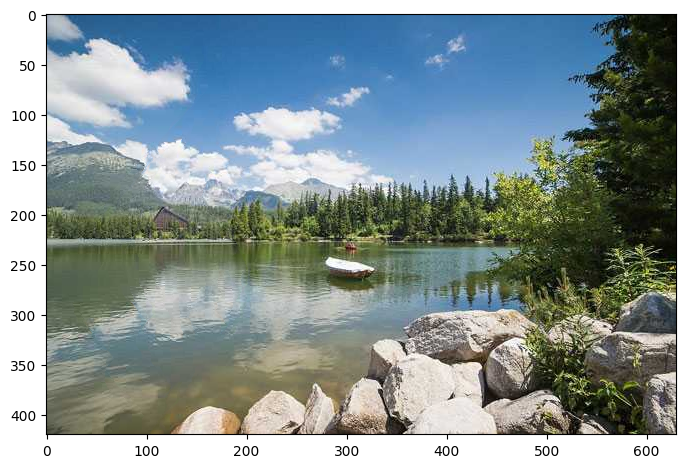

In [25]:
affichage("Image_test_3.jpg",seams_deletion,0.1)

Çi-dessous l'image de taille normale avec identifiés en rouge les chemins permettant de réduire la largeur de l'image de 10% :

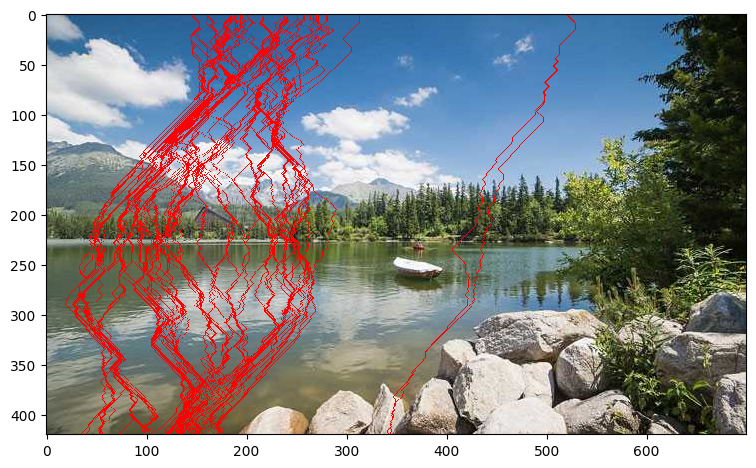

In [26]:
affichage("Image_test_3.jpg",seams_coloration,0.1)

Çi-dessous l'image augmentée en largeur de 10% :

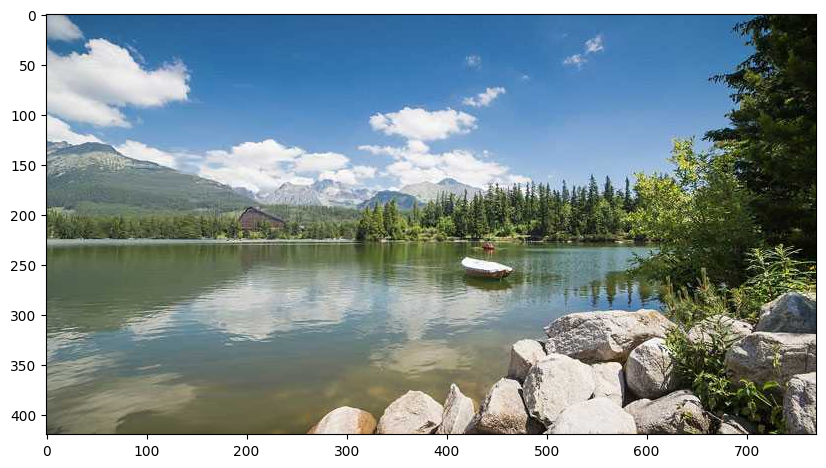

In [27]:
affichage("Image_test_3.jpg",seams_insertion,0.1)

On s'est jusqu'ici attelé à modifier la largeur d'une image mais l'on aurait très bien pu également inclure la possibilité de modifier la hauteur en faisant simplement subir à l'image une rotation de 90 degrés et en lui appliquant les programmes précédents. 

Le programme çi-dessous permet d'effectuer cette rotation.

In [28]:
"""Définition de la fonction permettant de tourner l'image de 90 degrés dans le sens direct"""
def rotate_image(image, degrees): 
    image=image 
    rotated_image = np.rot90(image, k=int(degrees/90))
    return rotated_image

On s'attardera uniquement à réécrire le programme seams_deletion qui permettra désormais de réduire la largeur et la hauteur d'une image en précisant les pourcentages de réduction respectifs.

In [29]:
"""Définition de la fonction permettant de diminuer la largeur et la hauteur d'une image d'un certain pourcentage"""
def new_seams_deletion(img, pct_L, pct_H):
    image=plt.imread(img)
    r, c, _ = image.shape
    nb_c=int(c*pct_L)
    nb_l=int(r*pct_H)
    if _==4:
        rgba_image = PIL.Image.open(img)
        image = np.array(rgba_image.convert('RGB'))

    for i in range(nb_c):
        seam = find_seam(image)[1]
        image=delete_seam(image, seam)
        
    image = rotate_image(image, 90)
    for i in range(nb_l):
        seam = find_seam(image)[1]
        image=delete_seam(image, seam)
    
    image = rotate_image(image, -90)
    return image

Temps d'exécution de l'affichage pour une réduction de 10% en largeur et en hauteur : environ 1 min 47

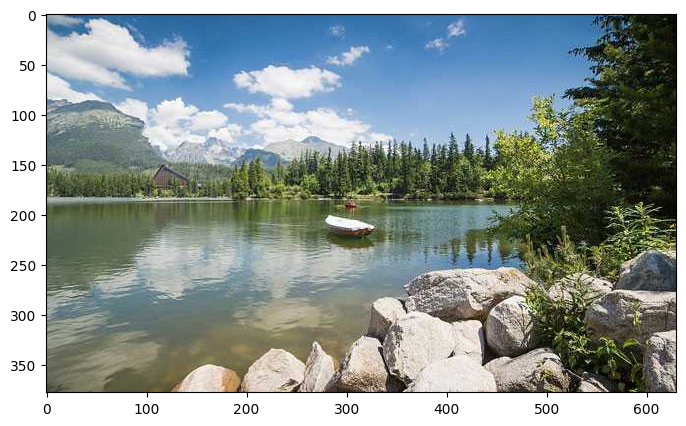

In [30]:
#Affichage 
img=new_seams_deletion("Image_test_3.jpg", 0.1, 0.1)
r, c, _ = img.shape
dpi = plt.rcParams['figure.dpi']
figsize = c/float(dpi), r/float(dpi)
fig=plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
plt.imshow(img)
#plt.axis('off')
plt.show()

## III) <ins>Conclusion et résultats</ins>

On constate à l'exécution que la méthode Seam Carving est plutôt satisfaisante dans la globalité des cas, pour des pourcentage de réduction et d'augmentation allant jusqu'à 20%.
<br>
On notera par ailleurs : 
- la longueur d'exécution des programmes pour des pourcentages plus élevés ou pour des images ayant une résolution plus importante ;
- les résultats moins satisfaisants pour des images plus détaillées et présentant des formes plus complexes

<div style="text-align:justify;">Cela dit, et c'est là que la méthode gagne en intérêt, il est possible en détourant certaines zones de pixels de l'image dont on souhaite qu'elles ne soient pas impactées par des modifications, de créé un masque délimitant ces zones et de l'utiliser de façon à changer la valeur "d'énergie" des pixels considérés afin de faire en sorte que les chemins épargnent ces zones de l'image : en leur donnant donc ici une "énergie" plus importante.</div>

<div style="text-align:justify;">Et on peut faire le raisonnement inverse en souhaitant au contraire supprimer certains éléments de l'image auquel cas les pixels contenus dans les zones détourées devront se voir attribuer une "énergie" moins importante de façon à forcer les chemins à passer par ces zones.</div>

Çi-dessous se trouve un exemple de suppression d'élément opérée sur l'image test : la bateau a été enlevé.

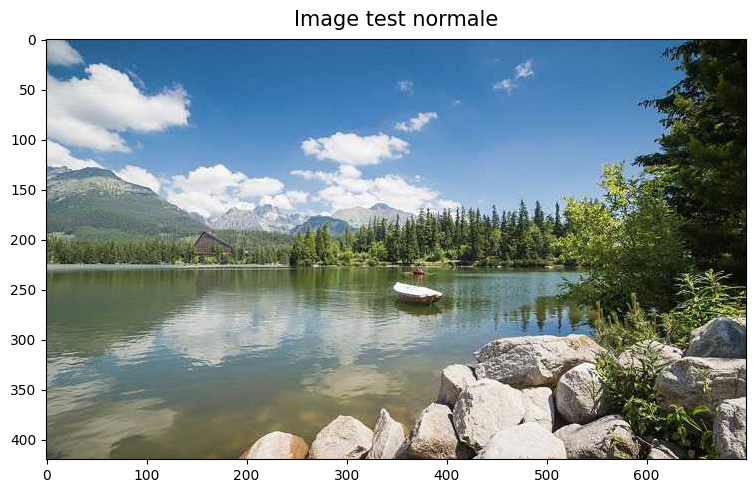

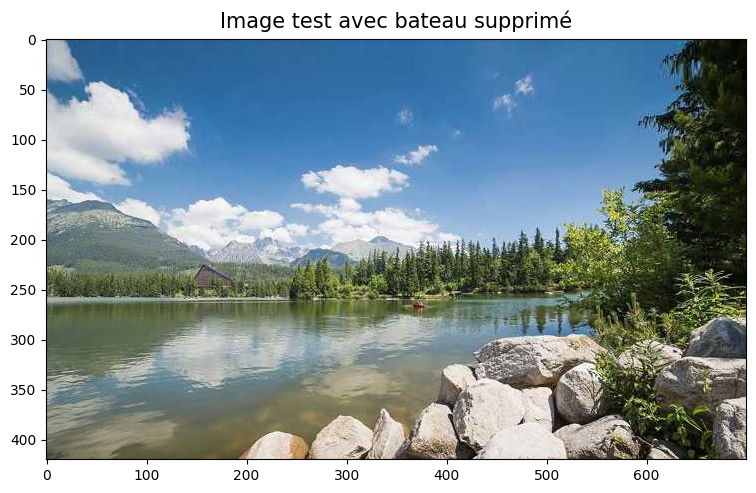

In [37]:
l=["Image_test_3.jpg","image_test_3_removed_vf.png"]
for i in l:
    img=plt.imread(i)
    r, c, _ = img.shape
    dpi = plt.rcParams['figure.dpi']
    figsize = c/float(dpi), r/float(dpi)
    fig=plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    plt.imshow(img)
    if i=="Image_test_3.jpg":
        plt.suptitle("Image test normale",fontsize=15, fontweight='light', horizontalalignment='center',y=1.07)
    else :
        plt.suptitle("Image test avec bateau supprimé",fontsize=15, fontweight='light', horizontalalignment='center',y=1.07)
    #plt.axis('off')
    plt.show()

Étant donné que cette opération nécessite un mode intéractif de matplotlib indisponible sur le JupyterHub de la Sorbonne, des détails sur le code ayant permis la réalisation de cette opération seront donnés lors de l'exposé oral.

## IV) <ins>Bibliographie</ins>

- https://www.sciencedirect.com/topics/computer-science/derivative-kernel
- https://fr.wikipedia.org/wiki/Filtre_de_Sobel
- https://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf
- https://mpechaud.fr/scripts/traitementimages/seamcarving.html#:~:text=Pour%20calculer%20l%27%C3%A9nergie%20E,pixel%20(i%2Cj).
- https://www.alanzucconi.com/2023/05/29/seam-carving/
- https://www.researchgate.net/publication/239398674_An_Isotropic_3x3_Image_Gradient_Operator/link/557e06f508aeea18b777c389/download?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19